In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from fatFunctions import fat_init, fat
from parameters import *

p = fat_init()
n = len(Index)

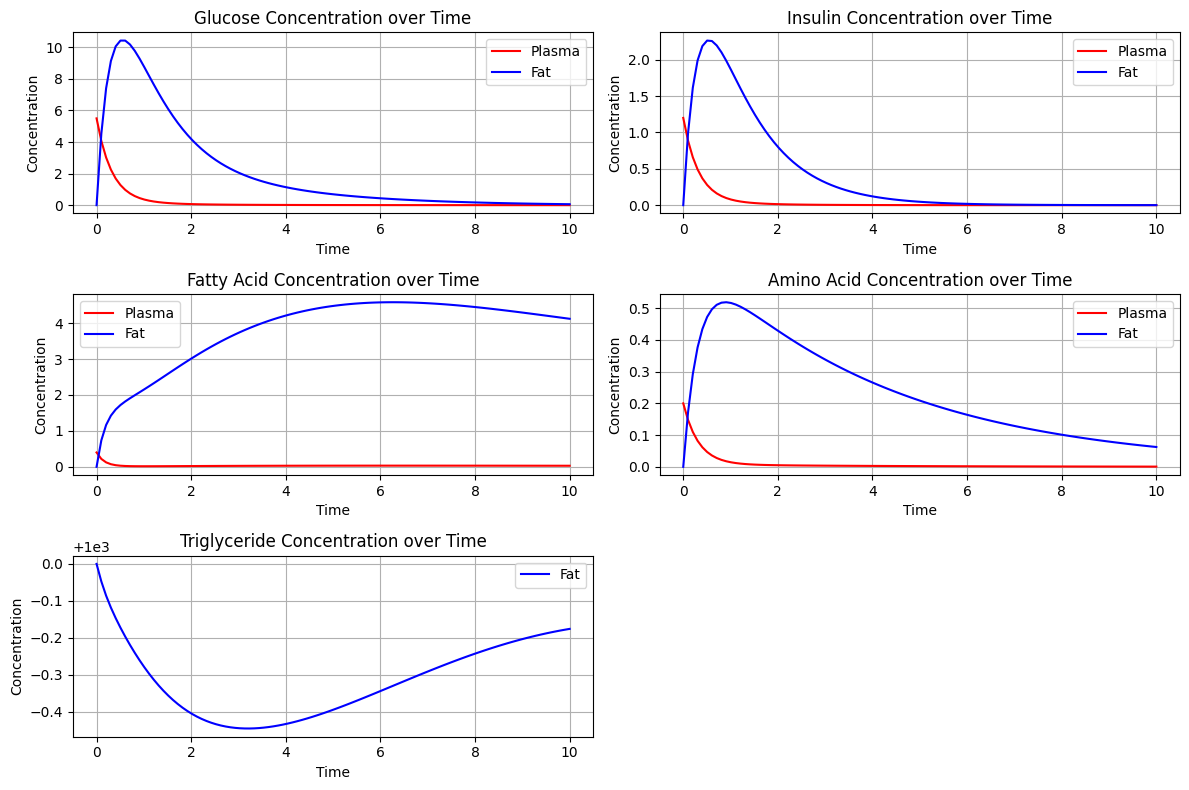

In [2]:
y0 = np.zeros(n)
y0[Index.plasma_glucose] = 5.5 #gmmol
y0[Index.plasma_insulin] = 1.2 #g/L
y0[Index.plasma_fattyacid] = 0.4 #mmol/L
y0[Index.plasma_aminoacid] = 0.2 #mmol/L
y0[Index.vsc_TAG] = 10 * 1000 /p.V.vsc *.1




t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)


solution = solve_ivp(fun=lambda t, y: fat(t, y, p, n),
                     t_span=t_span,
                     y0=y0,
                     t_eval=t_eval,
                     method='LSODA')

timespan = solution.t   
glucoseplasma = solution.y[Index.plasma_glucose]
glucosefat = solution.y[Index.vsc_glucose]
triglycerides = solution.y[Index.vsc_TAG]

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(timespan, glucoseplasma, label='Plasma', color='red')
plt.plot(timespan, glucosefat, label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Glucose Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(timespan, solution.y[Index.plasma_insulin], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.vsc_insulin], label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Insulin Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(timespan, solution.y[Index.plasma_fattyacid], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.vsc_fattyacid], label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fatty Acid Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(timespan, solution.y[Index.plasma_aminoacid], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.vsc_aminoacid], label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Amino Acid Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(timespan, triglycerides, label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Triglyceride Concentration over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

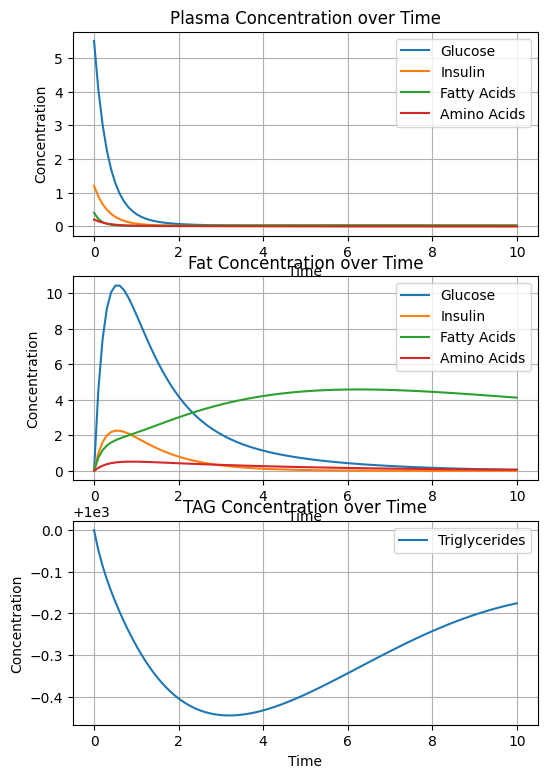

In [8]:
plt.figure(figsize=(6, 9))
plt.subplot(3, 1, 1)
plt.plot(timespan, solution.y[Index.plasma_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.plasma_insulin], label='Insulin')
plt.plot(timespan, solution.y[Index.plasma_fattyacid], label='Fatty Acids')
plt.plot(timespan, solution.y[Index.plasma_aminoacid], label='Amino Acids')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Plasma Concentration over Time')
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.plot(timespan, solution.y[Index.vsc_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.vsc_insulin], label='Insulin')
plt.plot(timespan, solution.y[Index.vsc_fattyacid], label='Fatty Acids')
plt.plot(timespan, solution.y[Index.vsc_aminoacid], label='Amino Acids')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fat Concentration over Time')
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)

plt.plot(timespan, solution.y[Index.vsc_TAG], label='Triglycerides')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('TAG Concentration over Time')
plt.legend()
plt.grid(True)

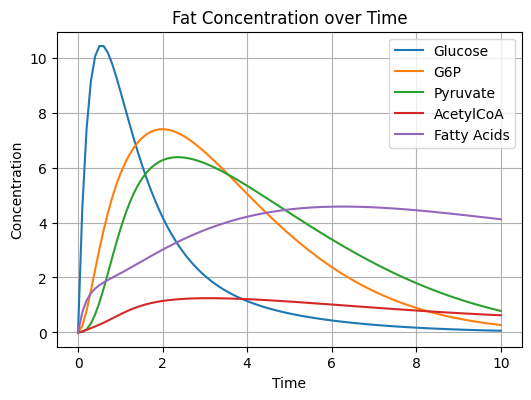

In [10]:
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(timespan, solution.y[Index.vsc_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.vsc_G6P], label='G6P')
plt.plot(timespan, solution.y[Index.vsc_pyruvate], label='Pyruvate')
plt.plot(timespan, solution.y[Index.vsc_ACoA], label='AcetylCoA')
plt.plot(timespan, solution.y[Index.vsc_fattyacid], label='Fatty Acids')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fat Concentration over Time')
plt.legend()
plt.grid(True)


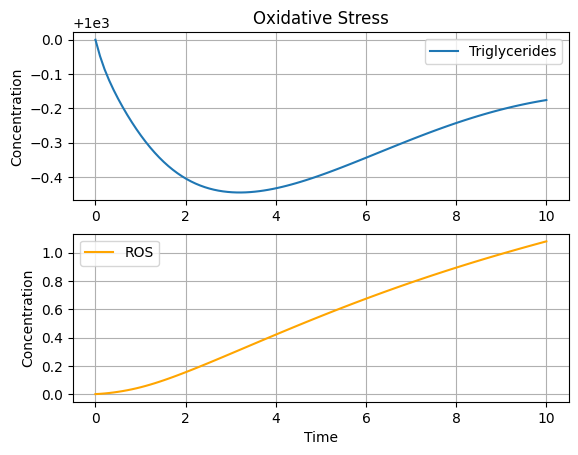

In [11]:
plt.subplot(2, 1, 1)
plt.plot(timespan, triglycerides, label='Triglycerides')


plt.ylabel('Concentration')
plt.title('Oxidative Stress')
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)

plt.plot(timespan, solution.y[Index.vsc_ROS], label='ROS', color='orange')
plt.xlabel('Time')
plt.ylabel('Concentration')

plt.legend()
plt.grid(True)

/tmp/ipykernel_188576/84114612.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_188576/84114612.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


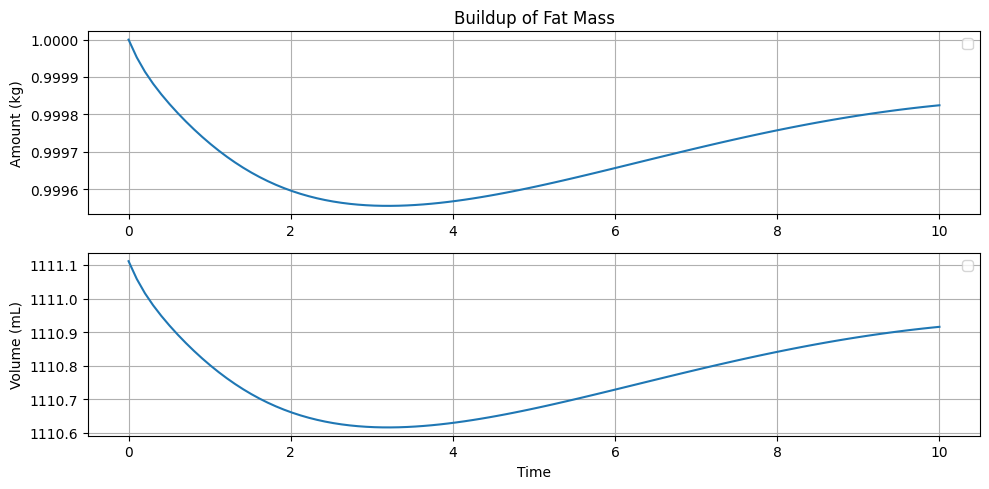

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(10, 5))

# First subplot
ax1 = plt.subplot(2, 1, 1)
ax1.plot(timespan, triglycerides * p.V.vsc / 1000)
ax1.set_ylabel('Amount (kg)')
ax1.set_title('Buildup of Fat Mass')
ax1.legend()
ax1.grid(True)

# Disable scientific notation on y-axis of subplot 1
formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax1.yaxis.set_major_formatter(formatter)

# Second subplot
ax2 = plt.subplot(2, 1, 2)
ax2.plot(timespan, triglycerides / 0.9)
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume (mL)')
ax2.legend()
ax2.grid(True)

# Disable scientific notation on y-axis of subplot 2
formatter2 = ScalarFormatter(useMathText=False)
formatter2.set_scientific(False)
formatter2.set_useOffset(False)
ax2.yaxis.set_major_formatter(formatter2)

plt.tight_layout()
plt.show()
